In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pathlib
from collections import Counter
import pickle
from skimage import io, transform
import cv2
from tqdm.notebook import tqdm

%matplotlib inline

In [3]:
DATASET_PATH = '/home/ilambda/DeepFashion/Category_and_Attribute_prediction_benchmark'
YOLO_DATASET_PATH = '/home/ilambda/DeepFashion/yolo'

### Original Dataset containing the ground truth bounding box

In [4]:
bbox_img = pd.read_csv('deepfashion_yolo.csv', index_col='index')
bbox_img.head()

image_name  x_1  y_1  x_2  y_2  \
index                                                                        
0      img/Sheer_Pleated-Front_Blouse/img_00000001.jpg   72   79  232  273   
1      img/Sheer_Pleated-Front_Blouse/img_00000002.jpg   67   59  155  161   
2      img/Sheer_Pleated-Front_Blouse/img_00000003.jpg   65   65  156  200   
3      img/Sheer_Pleated-Front_Blouse/img_00000004.jpg   51   62  167  182   
4      img/Sheer_Pleated-Front_Blouse/img_00000005.jpg   46   88  166  262   

              x         y     width    height  category_label  ...  \
index                                                          ...   
0      0.506667  0.586667  0.533333  0.646667               3  ...   
1      0.541463  0.366667  0.429268  0.340000               3  ...   
2      0.533816  0.441667  0.439614  0.450000               3  ...   
3      0.545000  0.488000  0.580000  0.480000               3  ...   
4      0.530000  0.583333  0.600000  0.580000               3  ...   

                   name      new_name new_x_1 new_y_1 new_x_2  new_y_2  \
index                                                                    
0      img_00000001.jpg  0_Blouse.jpg     107     117     346      407   
1      img_00000002.jpg  1_Blouse.jpg     146      88     338      240   
2      img_00000003.jpg  2_Blouse.jpg     140      97     337      298   
3      img_00000004.jpg  3_Blouse.jpg     114     111     374      326   
4      img_00000005.jpg  4_Blouse.jpg     103     131     371      391   

          new_x     new_y  new_width  new_height  
index                                             
0      0.505580  0.584821   0.533482    0.647321  
1      0.540179  0.366071   0.428571    0.339286  
2      0.532366  0.440848   0.439732    0.448661  
3      0.544643  0.487723   0.580357    0.479911  
4      0.529018  0.582589   0.598214    0.580357  

[5 rows x 23 columns]

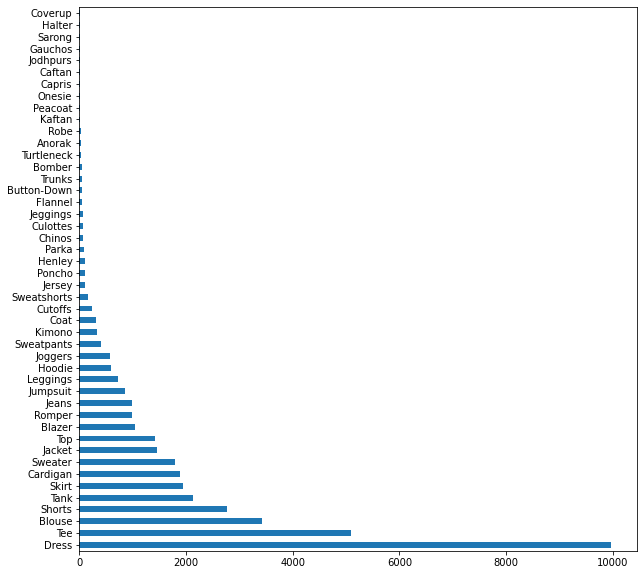

In [448]:
plt.figure(figsize=(10,10))
bbox_img[(bbox_img.evaluation_status == 'test')]['category_name'].value_counts().plot(kind='barh')
plt.show()

/home/ilambda/DeepFashion/yolo/815_Blazer.jpg

### Training with DarkNet
In order to build the darknet code in local
- make sure to make changes to the Makefile
   - GPU=1
   - CUDNN=1
- make sure /usr/local/cuda/bin is in PATH
- build the code by calling "make" command
- Prepare the data as shown below before starting the training
- Run the command to start training
    
    ./darknet -i 0 detector train cfg/deepfashion.data cfg/yolov3-deepfashion.cfg darknet53.conv.74

#### Data preparation
In order to train with DarkNet, we need to convert our dataset and labels to a certain format
- made changes to the category_label to start from 0 (instead originally starting from 1). So Blouse is 2 instead of original 3
- for each image, the label should be a separate .txt file with the same name as the image name. This file should have a single line with data (category_label, x, y, width, height)
- x, y, width, height should be normalized with image size
- create a separate file for each training, val and text containing the name of the image files
    - yolo_train.txt
    - yolo_val.txt
- create a file containing the class-names correspnding to the category-ids (deepfashion.name)
- update the file in cfg/deepfashion.data
- update the parameters in cfg/yolov3-deepfashion.cfg
    - change the number of classes to 50
    - make changes to the [yolo] layer filters to (classes+5) * 3 = 165

In [81]:
def save_txt(name, text):
    with open(name, 'w+') as f:
        f.write(text)

def create_yolo_label_files(df, split_type, rootdir=YOLO_DATASET_PATH):
    """
    :param: split_type in (train, val, test)
    """
    df = df[df.evaluation_status == split_type]
    df['category_label'] = df['category_label'].apply(lambda x: x-1)
    indices = df.index
    file_names = []
    for idx in indices:
        img_name = df.loc[idx]['new_name']
        name = rootdir + "/" + img_name.split('.')[0] + ".txt"
        text = ' '.join(df.loc[idx][['category_label', 'new_x', 'new_y', 'new_width', 'new_height']].astype(str).values)
        save_txt(name, text)
        file_names.append(rootdir + "/" + img_name)
    np.savetxt('yolo_'+split_type+'.txt', file_names, fmt='%s')

### Create txt file for training with DarkNet

In [83]:
create_yolo_label_files(bbox_img, "val")

/home/ilambda/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


#### Remove the labels file

In [72]:
txt_files = [f for f in pathlib.Path(YOLO_DATASET_PATH).glob("*.txt")]
for x in txt_files:
    os.remove(x)

In [ ]:
bbox_img[['category_label', 'new_x', 'new_y', 'new_width', 'new_height']].to_csv('yolo_labels.csv', index_label='index')

### Darknet Results

In [24]:
results = open('/home/ilambda/darknet/result.txt').readlines()


In [90]:
results2 = open('/home/ilambda/darknet/backup/detections/result.txt').readlines()

In [98]:
results3 = open('/home/ilambda/darknet/backup/detections/result_80000.txt').readlines()

In [93]:
def parse_results(results):

    result_dict = {}
    for i,line in enumerate(results[:-1]):
        res = ''
        if line.rstrip().startswith('Enter'):
            iname = line.rstrip().split(': ')[1]
            iname = iname.split("/")[-1]
            try:
                if not results[i+1].rstrip().startswith('Enter'):
                    res = results[i+1].rstrip()
                    res = res.split(": ")[0]
            except IndexError:
                pass
            result_dict[iname] = res
            
    return result_dict

In [99]:
results_dict_3 = parse_results(results3)

In [96]:
def verify_results(dic):
    true = list(map(lambda x: x.split(".")[0].split("_")[1], list(dic.keys())))
    pred = list(dic.values())
    print(len(true))
    print(len(pred))
    corrects = sum([ true[i] == pred[i] for i in range(len(true))])
    print(f"Accuracy: {corrects/len(true)*100}")
    #return true, pred

In [101]:
verify_results(results_dict_3)

40000
40000
Accuracy: 55.645


In [45]:
sum([ true[i] == pred[i] for i in range(len(true))])

23550

#### Accuracy

In [48]:
23550/40000. * 100

58.875

In [47]:
sum([pred[i] == '' for i in range(len(pred))])

10146

## Data Prep for TrainYourOwnYolo

In [49]:
bbox_img.head()

image_name  x_1  y_1  x_2  y_2  \
index                                                                        
0      img/Sheer_Pleated-Front_Blouse/img_00000001.jpg   72   79  232  273   
1      img/Sheer_Pleated-Front_Blouse/img_00000002.jpg   67   59  155  161   
2      img/Sheer_Pleated-Front_Blouse/img_00000003.jpg   65   65  156  200   
3      img/Sheer_Pleated-Front_Blouse/img_00000004.jpg   51   62  167  182   
4      img/Sheer_Pleated-Front_Blouse/img_00000005.jpg   46   88  166  262   

              x         y     width    height  category_label  ...  \
index                                                          ...   
0      0.506667  0.586667  0.533333  0.646667               3  ...   
1      0.541463  0.366667  0.429268  0.340000               3  ...   
2      0.533816  0.441667  0.439614  0.450000               3  ...   
3      0.545000  0.488000  0.580000  0.480000               3  ...   
4      0.530000  0.583333  0.600000  0.580000               3  ...   

                   name      new_name new_x_1 new_y_1 new_x_2  new_y_2  \
index                                                                    
0      img_00000001.jpg  0_Blouse.jpg     107     117     346      407   
1      img_00000002.jpg  1_Blouse.jpg     146      88     338      240   
2      img_00000003.jpg  2_Blouse.jpg     140      97     337      298   
3      img_00000004.jpg  3_Blouse.jpg     114     111     374      326   
4      img_00000005.jpg  4_Blouse.jpg     103     131     371      391   

          new_x     new_y  new_width  new_height  
index                                             
0      0.505580  0.584821   0.533482    0.647321  
1      0.540179  0.366071   0.428571    0.339286  
2      0.532366  0.440848   0.439732    0.448661  
3      0.544643  0.487723   0.580357    0.479911  
4      0.529018  0.582589   0.598214    0.580357  

[5 rows x 23 columns]

In [354]:
TRAINING_DATAFILE = '/home/ilambda/goods_viewer/Debasish/torch/TrainYourOwnYolo/training_data.txt'
TEST_DATAFILE = '/home/ilambda/goods_viewer/Debasish/torch/TrainYourOwnYolo/test_data.txt'
CATEGORY_NAMES = '/home/ilambda/goods_viewer/Debasish/torch/TrainYourOwnYolo/deepfashion.name'
INFERENCE_DIR = '/home/ilambda/goods_viewer/Debasish/TrainYourOwnYOLO/3_Inference'
TEST_IMAGES_PATH = '/home/ilambda/goods_viewer/Debasish/TrainYourOwnYOLO/3_Inference/test_images'

In [55]:
row = bbox_img.iloc[0][['new_name', 'new_x_1','new_y_1','new_x_2', 'new_y_2','category_label']].to_numpy()

### Data format in the training txt file

In [59]:
row

array(['0_Blouse.jpg', 107, 117, 346, 407, 3], dtype=object)

In [67]:
def create_yolo_training(df, imagedir=YOLO_DATASET_PATH):
    indices = df.index
    rows = []
    for idx in indices:
        r = bbox_img.loc[idx][['new_name', 'new_x_1','new_y_1','new_x_2', 'new_y_2','category_label']].to_numpy()
        r[0] = YOLO_DATASET_PATH + "/" + r[0]
        r[5] = r[5] - 1
        row = f"{r[0]} {r[1]},{r[2]},{r[3]},{r[4]},{r[5]}"
        
        rows.append(row)
    np.savetxt(TRAINING_DATAFILE, rows, fmt='%s')
    print(f"Saved {len(rows)} records to the file {TRAINING_DATAFILE}")
        

In [68]:
create_yolo_training(bbox_img[bbox_img.evaluation_status == 'train'])

Saved 209222 records to the file /home/ilambda/goods_viewer/Debasish/torch/TrainYourOwnYolo/training_data.txt


### Evaluation

In [165]:
random_state = 43

In [166]:
test_images = bbox_img[bbox_img.evaluation_status == 'test']['new_name'].apply(lambda x: os.path.join(YOLO_DATASET_PATH, x))

In [179]:
len(test_images)

40000

In [167]:
test_image_names = shuffle(test_images, random_state=random_state)

In [153]:
from sklearn.utils import shuffle
import shutil
import pickle

os.mkdir(os.path.join(INFERENCE_DIR, "test_images"))

In [145]:
categories = np.loadtxt('deepfashion.name', dtype=str)

In [180]:
num_test_images = len(test_images)

Copy the images to <b>/home/ilambda/goods_viewer/Debasish/TrainYourOwnYOLO/3_Inference/test_images</b>
<br>Run the command

python Detector.py --input_path 'test_images' --output 'det2' --no_save_img  --box_file 'det2/Detection_Results.csv' --classes '/home/ilambda/goods_viewer/Debasish/torch/TrainYourOwnYolo/deepfashion.name' --postfix ''

In [181]:
for f in test_image_names.values[:num_test_images]:
    shutil.copy(f, os.path.join(INFERENCE_DIR, "test_images"))

### Results

In [185]:
results_df = pd.read_csv(os.path.join(INFERENCE_DIR, "det2", "Detection_Results_all.csv"))
results_df['label_category'] = results_df['label'].apply(lambda x: categories[x])

In [186]:
results_df.head()

image                    image_path  xmin  ymin  xmax  ymax  \
0  284841_Dress.jpg  test_images/284841_Dress.jpg    64    47   360   422   
1    122273_Tee.jpg    test_images/122273_Tee.jpg    72    90   378   378   
2  250416_Dress.jpg  test_images/250416_Dress.jpg    40    81   420   438   
3  195145_Jeans.jpg  test_images/195145_Jeans.jpg   116     3   338   428   
4  19305_Blazer.jpg  test_images/19305_Blazer.jpg    88   121   378   372   

   label  confidence  x_size  y_size label_category  
0     40    0.969700     448     448          Dress  
1     17    0.908269     448     448            Tee  
2     40    0.889850     448     448          Dress  
3     25    0.968304     448     448          Jeans  
4      1    0.975007     448     448         Blazer

In [187]:
tnames = test_image_names[:num_test_images]
tnames = list(map(lambda x: x.split('/')[-1],tnames))

In [188]:
len(results_df.image.unique())

35829

In [141]:
def find_accuracy(test_images, df):
    total = len(test_images)
    true = 0
    #cats = list(map(lambda x: x.split('.')[0].split('_')[1], test_images))
    for im in test_images:
        categories = df[df.image == im]['label_category'].values
        cat = im.split('.')[0].split('_')[1]
        if cat in set(categories):
            true +=1
            
    accuracy = true/float(total)*100
    return accuracy


In [189]:
find_accuracy(tnames, results_df)

65.49249999999999

In [182]:
loss = np.loadtxt('/home/ilambda/goods_viewer/Debasish/TrainYourOwnYOLO/Data/Model_Weights/1587074130/step2_loss.npy')
val_loss = np.loadtxt('/home/ilambda/goods_viewer/Debasish/TrainYourOwnYOLO/Data/Model_Weights/1587074130/step2_val_loss.npy')

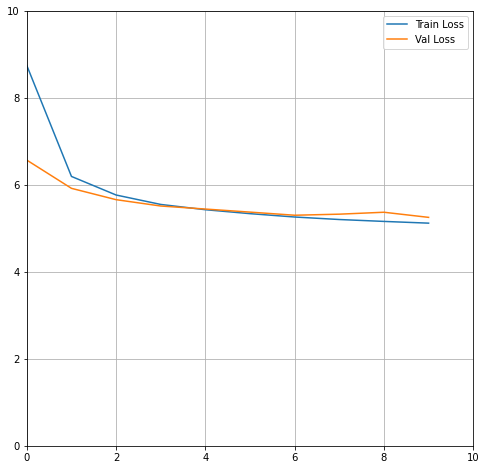

In [444]:
plt.figure(figsize=(8,8))
plt.plot(loss, label="Train Loss")
plt.plot(val_loss, label="Val Loss")
plt.xlim(0,10)
plt.ylim(0,10)
plt.legend()
plt.grid()
plt.show()

In [214]:
top1_df = results_df[['image','confidence','label_category']].groupby('image').max()
top1_df = top1_df.reset_index()
top1_df['group'] = top1_df['image'].apply(lambda x: x.split('.')[0].split('_')[-1])
top1_accuracy = sum(top1_df['label_category'] == top1_df['group'])/float(len(results_df))*100
top1_accuracy

52.129625456348315

In [224]:
results_df.head()

image                    image_path  xmin  ymin  xmax  ymax  \
0  284841_Dress.jpg  test_images/284841_Dress.jpg    64    47   360   422   
1    122273_Tee.jpg    test_images/122273_Tee.jpg    72    90   378   378   
2  250416_Dress.jpg  test_images/250416_Dress.jpg    40    81   420   438   
3  195145_Jeans.jpg  test_images/195145_Jeans.jpg   116     3   338   428   
4  19305_Blazer.jpg  test_images/19305_Blazer.jpg    88   121   378   372   

   label  confidence  x_size  y_size label_category  
0     40    0.969700     448     448          Dress  
1     17    0.908269     448     448            Tee  
2     40    0.889850     448     448          Dress  
3     25    0.968304     448     448          Jeans  
4      1    0.975007     448     448         Blazer

In [245]:
results_df['actual_label'] = results_df['image'].apply(lambda x: x.split('.')[0].split('_')[-1])

In [248]:
24137/40000

0.603425

In [257]:
test_df = results_df[['image','confidence', 'label_category', 'actual_label']].copy()

In [260]:
test_df.head()

image  confidence label_category actual_label
0  284841_Dress.jpg    0.969700          Dress        Dress
1    122273_Tee.jpg    0.908269            Tee          Tee
2  250416_Dress.jpg    0.889850          Dress        Dress
3  195145_Jeans.jpg    0.968304          Jeans        Jeans
4  19305_Blazer.jpg    0.975007         Blazer       Blazer

In [263]:
grouped_test = test_df.groupby('image')['label_category'].apply(list).reset_index()

In [265]:
grouped_test['true_category'] = grouped_test['image'].apply(lambda x: x.split('.')[0].split('_')[-1])

In [268]:
grouped_test.head()

image label_category true_category
0  100007_Tee.jpg    [Tee, Tank]           Tee
1  100009_Tee.jpg         [Tank]           Tee
2  100014_Tee.jpg          [Tee]           Tee
3  100023_Tee.jpg        [Jeans]           Tee
4  100026_Tee.jpg          [Tee]           Tee

In [275]:
sum(grouped_test.apply(lambda x: x['true_category'] in set(x['label_category']), axis=1))

26197

In [276]:
26197/40000

0.654925

In [278]:
test_df['max_confidence'] = test_df.groupby('image')['confidence'].transform(max)

In [280]:
test_df_toppred = test_df[(test_df.confidence == test_df.max_confidence)]

In [283]:
len(test_df_toppred[(test_df_toppred.actual_label == test_df_toppred.label_category)])

24137

In [284]:
24137/40000

0.603425

In [286]:
correct_preds = test_df_toppred[(test_df_toppred.actual_label == test_df_toppred.label_category)]

In [297]:
preds = correct_preds.groupby('actual_label')['label_category'].apply(len).to_dict()

In [298]:
actuals = bbox_img[bbox_img.evaluation_status == 'test'][['new_name','category_name']].groupby('category_name')['new_name'].apply(len).to_dict()

In [449]:
def accuracy(tup):
    key = tup[0]
    val = tup[1]
    pred = preds.get(key) if preds.get(key) else 0
    return pred/val

In [450]:
accuracy_by_categories = {tup[0]:accuracy(tup) for tup in actuals.items()}

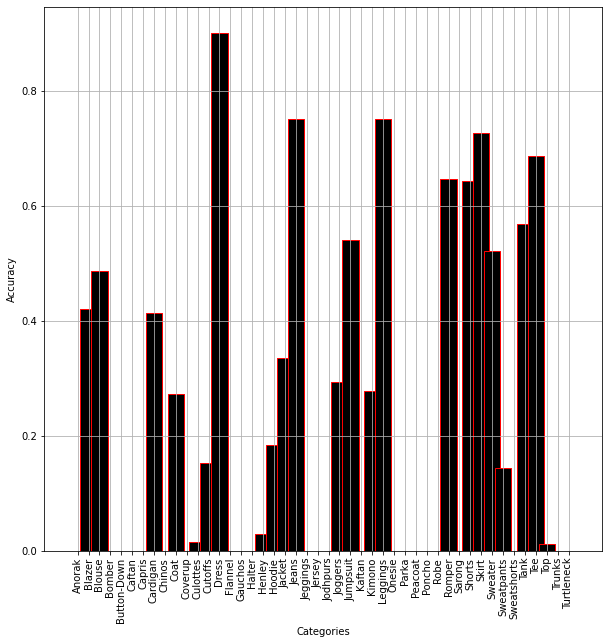

In [467]:
plt.figure(figsize=(10,10))
plt.bar(accuracy_by_categories.keys(), list(accuracy_by_categories.values()), width=1.5, edgecolor='red', color='black')
plt.xticks(rotation=90)
plt.ylabel('Accuracy')
plt.xlabel('Categories')
plt.grid()
plt.show()

In [304]:
aa = results_df.groupby('image')

### Find the predictions with max confidence for each image

In [309]:
results_df.loc[aa['confidence'].idxmax()]

image                        image_path  xmin  ymin  \
20296        100007_Tee.jpg        test_images/100007_Tee.jpg    84    52   
25360        100009_Tee.jpg        test_images/100009_Tee.jpg    52    66   
21959        100014_Tee.jpg        test_images/100014_Tee.jpg     6     0   
5672         100023_Tee.jpg        test_images/100023_Tee.jpg   136   139   
21036        100026_Tee.jpg        test_images/100026_Tee.jpg     0    34   
...                     ...                               ...   ...   ...   
10665         99949_Top.jpg         test_images/99949_Top.jpg   127    65   
33986  9994_Button-Down.jpg  test_images/9994_Button-Down.jpg   107   103   
20879         99955_Top.jpg         test_images/99955_Top.jpg    53   275   
26858         99969_Top.jpg         test_images/99969_Top.jpg     0   188   
16215         99976_Top.jpg         test_images/99976_Top.jpg    33   124   

       xmax  ymax  label  confidence  x_size  y_size label_category  max_conf  \
20296   354   410     17    0.865687     448     448            Tee  0.865687   
25360   378   431     16    0.745176     448     448           Tank  0.745176   
21959   440   448     17    0.958183     448     448            Tee  0.958183   
5672    294   440     25    0.803495     448     448          Jeans  0.803495   
21036   448   448     17    0.882792     448     448            Tee  0.882792   
...     ...   ...    ...         ...     ...     ...            ...       ...   
10665   370   291     16    0.326658     448     448           Tank  0.326658   
33986   344   396     17    0.808695     448     448            Tee  0.808695   
20879   321   394     31    0.262051     448     448         Shorts  0.262051   
26858   448   448     17    0.528758     448     448            Tee  0.528758   
16215   374   374     17    0.481701     448     448            Tee  0.481701   

      actual_label  
20296          Tee  
25360          Tee  
21959          Tee  
5672           Tee  
21036          Tee  
...            ...  
10665          Top  
33986  Button-Down  
20879          Top  
26858          Top  
16215          Top  

[35829 rows x 13 columns]

## Model Output visualization

In [357]:
from PIL import Image, ImageFont, ImageShow, ImageDraw

In [310]:
PROCESSED_IMAGE_PATH = '/home/ilambda/goods_viewer/Debasish/TrainYourOwnYOLO/3_Inference/detection'

In [314]:
processed_images = [f for f in pathlib.Path(PROCESSED_IMAGE_PATH).glob("*.jpg")]

#plt.figure(constrained_layout=True)
fig, axes = plt.subplots(8,2, figsize=(20,40))
k = 10
for i in range(8):
    for j in range(2):
        im = Image.open(processed_images[k])
        axes[i][j].imshow(im)
        axes[i][j].set_title(processed_images[k].name)
        k+=1
plt.tight_layout()

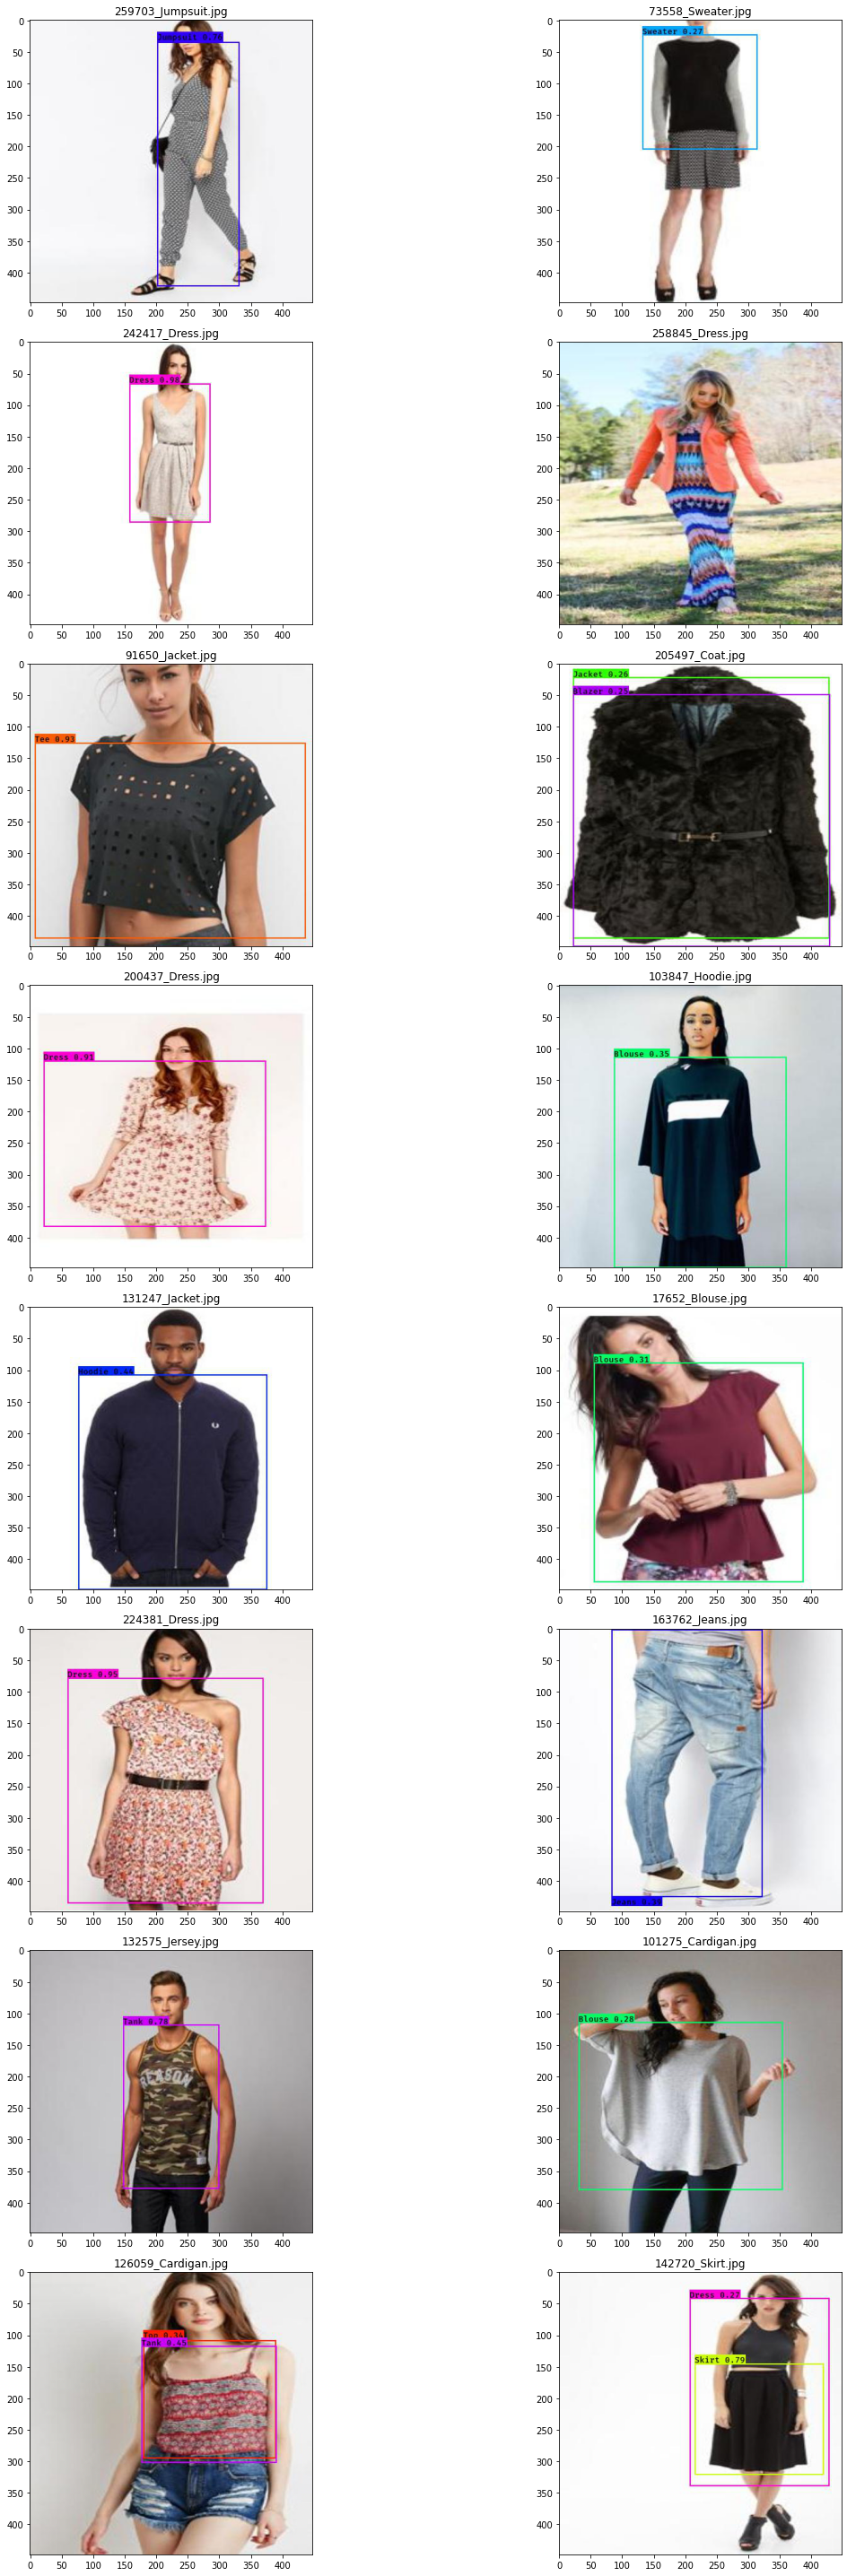

In [351]:
fig, axes = plt.subplots(8,2, figsize=(20,40))
k = 10
for ax in axes.flat:
        im = Image.open(processed_images[k])
        ax.imshow(im)
        ax.set_title(processed_images[k].name)
        k+=1
plt.tight_layout()

row = results_df.loc[0]
ipath = os.path.join(TEST_IMAGES_PATH, row['image'])
im = Image.open(ipath)
draw = ImageDraw.Draw(im)
draw.rectangle([row['xmin'], row['ymin'], row['xmax'], row['ymax']], outline='red')
font = ImageFont.truetype("/usr/share/fonts/dejavu/DejaVuSans-Bold.ttf", size=18)
draw.text((10, 10),  f"{row['label_category']}:{row['confidence']:.2f}",fill=(0,1,0), font=font)
plt.imshow(im)
plt.show()

### Create visualization from the results dataframe

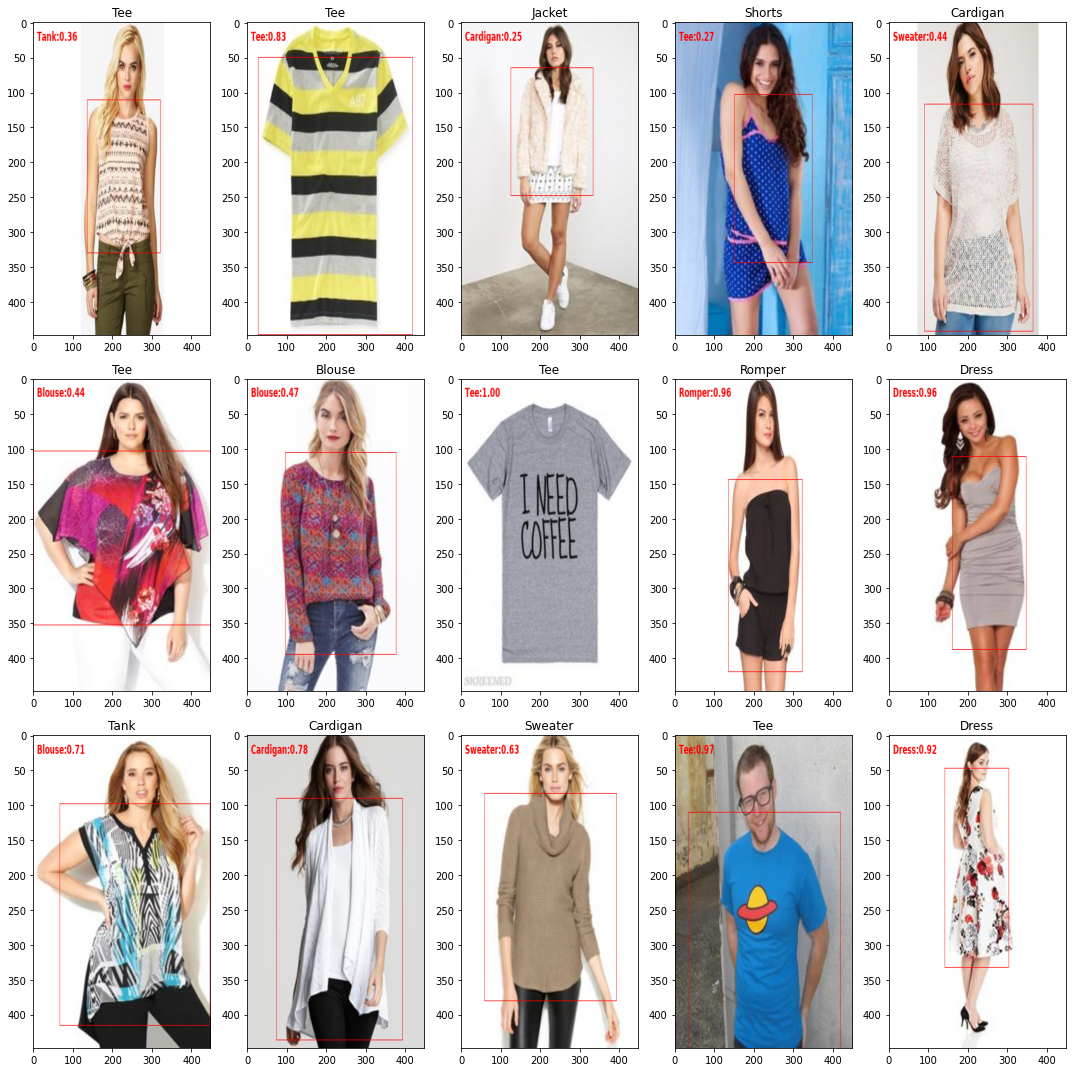

In [446]:
df = results_df[(results_df.confidence == results_df.max_conf)]
font = ImageFont.truetype("/usr/share/fonts/dejavu/DejaVuSans-Bold.ttf", size=18)
fig, axes = plt.subplots(3,5, figsize=(15,15))
indices = df.index
k = 50
for axis in axes.flat:
    row = df.loc[indices[k]]
    ipath = os.path.join(TEST_IMAGES_PATH, row['image'])
    im = Image.open(ipath)
    draw = ImageDraw.Draw(im)
    draw.rectangle([row['xmin'], row['ymin'], row['xmax'], row['ymax']], outline='red', width=1)
    draw.text((10, 10),  f"{row['label_category']}:{row['confidence']:.2f}",fill=(255,0,0), font=font)
    axis.imshow(im, aspect='auto')
    axis.set_title(row['actual_label'])
    k+=1
plt.tight_layout()
plt.show()

In [555]:
def iou(row):
    true_x1 = row['new_x_1']
    true_y1 = row['new_y_1']
    true_x2 = row['new_x_2']
    true_y2 = row['new_y_2']
    pred_x1 = row['xmin']
    pred_y1 = row['ymin']
    pred_x2 = row['xmax']
    pred_y2 = row['ymax']
    inner_xmin = max(min(true_x1, true_x2), min(pred_x1, pred_x2))
    inner_xmax = min(max(true_x1, true_x2), max(pred_x1, pred_x2))
    inner_ymin = max(min(true_y1, true_y2), min(pred_y1, pred_y2))
    inner_ymax = min(max(true_y1, true_y2), max(pred_y1, pred_y2))
    #print(inner_xmin, inner_ymin, inner_xmax, inner_ymax)
    h1 = abs(true_y1 - true_y2)
    w1 = abs(true_x1 - true_x2)
    h2 = abs(pred_y1 - pred_y2)
    w2 = abs(pred_x1 - pred_x2)
    innerh = abs(inner_ymax - inner_ymin)
    innerw = abs(inner_xmax - inner_xmin)
    area_inner = innerh * innerw
    iou = (area_inner)/(h1*w1 + h2*w2 - area_inner)
    return (iou)

In [634]:
def draw_bb(df, index):
    plt.figure(figsize=(8,8))
    row = df.loc[index]
    ipath = os.path.join(TEST_IMAGES_PATH, row['image'])
    im = Image.open(ipath)
    draw = ImageDraw.Draw(im)
    draw.rectangle([row['xmin'], row['ymin'], row['xmax'], row['ymax']], outline=(255,0,0), width=1)
    draw.text((10, 10),  f"{row['predicted_label']}:{row['confidence']:.2f}",fill=(255,0,0), font=font)
    draw.rectangle([row['new_x_1'], row['new_y_1'], row['new_x_2'], row['new_y_2']], outline=(0,255,0), width=1)
    draw.text((300, 10),  f"{row['true_label']}",fill=(0,255,0), font=font)
    plt.imshow(im, aspect='auto')
    plt.title(row['true_label'])
    plt.show()

In [747]:
def create_pred_df(csv_name, source_df=test_df):
    df = pd.read_csv(os.path.join(INFERENCE_DIR, 'det2', csv_name))
    df['predicted_label'] = df['label'].apply(lambda x: categories[x])
    df['true_label'] = df['image'].apply(lambda x: x.split('.')[0].split('_')[-1])
    #print(df.shape)
    df = pd.merge(df, source_df, left_on='image', right_on='new_name')
    #print(df.shape)
    df['iou'] = df.apply(iou, axis=1)
    
    df['max_confidence'] = df.groupby('image')['confidence'].transform(max)
    print(df.shape)
    return df

def top1accuracy(pred_df, source_df=test_df):
    top1_pred = len(pred_df[(pred_df.confidence == pred_df.max_confidence) & (pred_df.predicted_label == pred_df.true_label)])
    top1_accuracy = top1_pred/len(source_df)
    print(f"top-1 accuracy = {top1_accuracy}")

def topnaccuracy(pred_df, source_df=test_df):
    xx = pred_df.groupby('image')['predicted_label'].apply(list).reset_index()
    xx['true_label'] = xx['image'].apply(lambda x: x.split('.')[0].split('_')[-1])
    topn_pred = sum(xx.apply(lambda row: row['true_label'] in set(row['predicted_label']), axis=1))
    print(f"top-n accuracy = {topn_pred/len(source_df)}")
    
def get_accuracies(pred_df, source_df=test_df):
    print(f"Total length of test set: {len(source_df)}")
    print(f"Total unique detections: {len(pred_df['image'].unique())}")
    top1accuracy(pred_df, source_df)
    topnaccuracy(pred_df, source_df)
    #print(f"Total ")
    

In [752]:
def display_bb_grid_(df, grid_shape=(3,5), image_path=TEST_IMAGES_PATH, show_true_box=True):
    color_palettes = [(255,0,0),(0,255,0), (0,0,255), (255,255,0), (0,255,255), (255,0,255)]
    #df = df[(df.confidence == df.max_confidence)]
    groups = df.groupby('image')
    it = iter(groups)
    font = ImageFont.truetype("/usr/share/fonts/dejavu/DejaVuSans-Bold.ttf", size=18)
    fig, axes = plt.subplots(grid_shape[0],grid_shape[1], figsize=(15,15))
    #indices = df.index
    #k = start_index
    for axis in axes.flat:
        image_name, idf  = next(it)
        idf = idf.sort_values('confidence', ascending=False)
        #indices = idf.index
        #row = df.loc[indices[k]]
        ipath = os.path.join(image_path, image_name)
        im = Image.open(ipath)
        draw = ImageDraw.Draw(im)
        # Predicted box
        for k,idx in enumerate(idf.index):
            row = idf.loc[idx]
            if show_true_box and k == 0:
                draw.rectangle([row['new_x_1'], row['new_y_1'], row['new_x_2'], row['new_y_2']], outline=(125,125,125), width=5)
            draw.rectangle([row['xmin'], row['ymin'], row['xmax'], row['ymax']], outline=color_palettes[k], width=2)
            draw.text((10, 10+(20*k)),  f"{row['predicted_label']}:{row['confidence']:.2f}",fill=color_palettes[k], font=font)
        axis.imshow(im, aspect='auto')
        axis.set_title(row['true_label'])
        #k+=1
    plt.tight_layout()
    plt.show()

In [748]:
latest_pred = create_pred_df('Detection_Results0427.csv')

(51328, 19)


In [749]:
latest_pred15 = create_pred_df('Detection_Results0427_conf15.csv')

(65802, 19)


In [750]:
get_accuracies(latest_pred15)

Total length of test set: 40000
Total unique detections: 39284
top-1 accuracy = 0.665875
top-n accuracy = 0.782725


In [751]:
get_accuracies(latest_pred)

Total length of test set: 40000
Total unique detections: 38334
top-1 accuracy = 0.659125
top-n accuracy = 0.730025


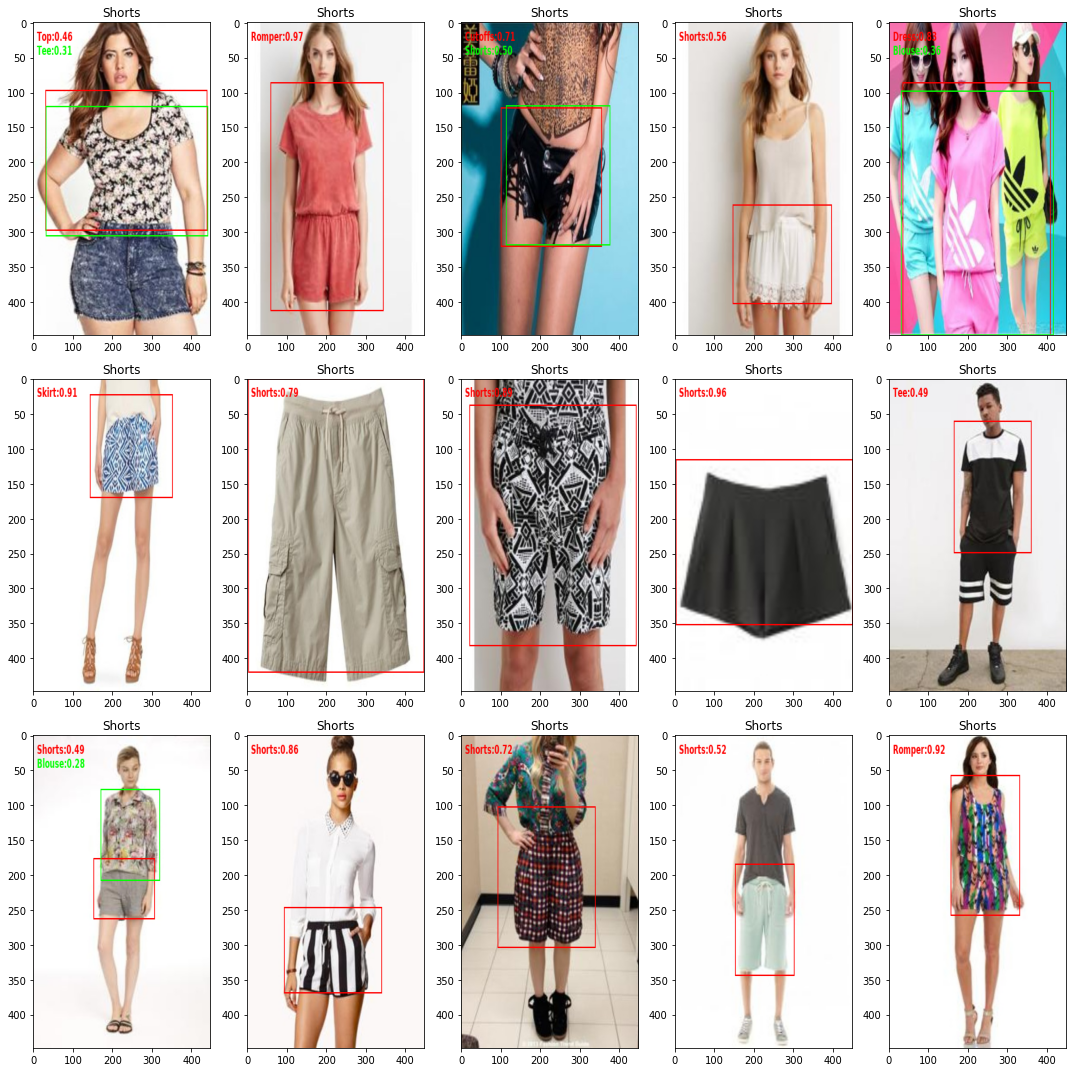

In [754]:
display_bb_grid_(latest_pred[latest_pred.true_label == 'Shorts'], show_true_box=False)

In [567]:
cols = ['image', 'true_label','predicted_label', 'new_x_1', 'new_y_1', 'new_x_2', 'new_y_2', 'xmin', 'ymin', 'xmax','ymax','confidence', 'iou']

### Dataframe containing true bounding box details

In [538]:
test_df = bbox_img[bbox_img.evaluation_status == 'test'][['new_name','new_x_1','new_y_1', 'new_x_2', 'new_y_2']]

### Dataframe containing predicted bounding box details

In [678]:
random_df = pd.read_csv(os.path.join(INFERENCE_DIR, 'det2', 'Detection_Results_conf_15.csv'))
random_df.shape

(61011, 10)

In [679]:
random_df.head()

image                    image_path  xmin  ymin  xmax  ymax  \
0  284841_Dress.jpg  test_images/284841_Dress.jpg    64    47   360   422   
1    122273_Tee.jpg    test_images/122273_Tee.jpg    72    90   378   378   
2  250416_Dress.jpg  test_images/250416_Dress.jpg    40    81   420   438   
3  250416_Dress.jpg  test_images/250416_Dress.jpg    55   117   447   447   
4  195145_Jeans.jpg  test_images/195145_Jeans.jpg   116     3   338   428   

   label  confidence  x_size  y_size  
0     40    0.969700     448     448  
1     17    0.908269     448     448  
2     40    0.889850     448     448  
3      2    0.207913     448     448  
4     25    0.968304     448     448

In [680]:
random_df['predicted_label'] = random_df['label'].apply(lambda x: categories[x])

random_df['true_label'] = random_df['image'].apply(lambda x: x.split('.')[0].split('_')[-1])

### Merge source and target df

In [668]:
random_df = pd.merge(random_df, test_df, left_on='image', right_on='new_name')

In [670]:
random_df['iou'] = random_df.apply(iou, axis=1)

In [681]:
print(f"Total unique detections: {len(random_df['image'].unique())}")

Total unique detections: 38180


In [683]:
xx = random_df.groupby('image')['predicted_label'].apply(list).reset_index()
xx['true_label'] = xx['image'].apply(lambda x: x.split('.')[0].split('_')[-1])

In [684]:
topn_pred = sum(xx.apply(lambda row: row['true_label'] in set(row['predicted_label']), axis=1))

In [685]:
print(f"top-n predictions = {topn_pred/40000}")

top-n predictions = 0.730875


In [686]:
random_df['max_confidence'] = random_df.groupby('image')['confidence'].transform(max)

In [687]:
top1_pred = len(random_df[(random_df.confidence == random_df.max_confidence) & (random_df.predicted_label == random_df.true_label)])

In [688]:
print(f"top-1 predictions = {top1_pred/40000}")

top-1 predictions = 0.621525
